# STEP 6: Calculate zonal statistics

In order to evaluate the connection between vegetation health and
redlining, we need to summarize NDVI across the same geographic areas as
we have redlining information.

First, import variables from previous notebooks:

In [1]:
store -r denver_redlining_gdf denver_ndvi_da denver_merged_das band_dict

no stored variable or alias denver_merged_das
no stored variable or alias band_dict


<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Import packages</div></div><div class="callout-body-container callout-body"><p>Some packages are included that will help you calculate statistics
for areas imported below. Add packages for:</p>
<ol type="1">
<li>Interactive plotting of tabular and vector data</li>
<li>Working with categorical data in <code>DataFrame</code>s</li>
</ol></div></div>

In [2]:
import os # Reproducible file paths
import re # Extract metadata from file names
import zipfile # Work with zip files
from io import BytesIO # Stream binary (zip) files
from glob import glob # Find files by pattern

import pandas as pd# Ordered categorical data
import numpy as np # Unpack bit-wise Fmask
import matplotlib.pyplot as plt # Make subplots
import requests # Request data over HTTP
import rioxarray as rxr # Work with geospatial raster data
import cartopy.crs as ccrs # CRSs
import hvplot.pandas # Interactive plots with pandas

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [4]:
# Interactive plots with pandas
# Ordered categorical data
import regionmask # Convert shapefile to mask
from xrspatial import zonal_stats # Calculate zonal statistics

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Convert vector to raster</div></div><div class="callout-body-container callout-body"><p>You can convert your vector data to a raster mask using the
<code>regionmask</code> package. You will need to give
<code>regionmask</code> the geographic coordinates of the grid you are
using for this to work:</p>
<ol type="1">
<li>Replace <code>gdf</code> with your redlining
<code>GeoDataFrame</code>.</li>
<li>Add code to put your <code>GeoDataFrame</code> in the same CRS as
your raster data.</li>
<li>Replace <code>x_coord</code> and <code>y_coord</code> with the x and
y coordinates from your raster data.</li>
</ol></div></div>

Create generic names so code can be generic below.

In [18]:
ndvi_da = denver_ndvi_da
redlining_gdf = denver_redlining_gdf
merged_das = denver_merged_das
place = "Denver"

In [17]:
plot_gdf = redlining_gdf.to_crs(ccrs.Mercator())
ndvi_plot_da = ndvi_da.rio.reproject(ccrs.Mercator())
band_plot_dict = {
    name: da.rio.reproject(ccrs.Mercator())
    for name, da in denver_merged_das.items()
}

In [14]:
band_dict.keys()

dict_keys(['green', 'red', 'aerosol', 'nir', 'thermalir2', 'thermalir1', 'blue', 'swir1', 'swir2', 'cirrus'])

## Redlining Mask

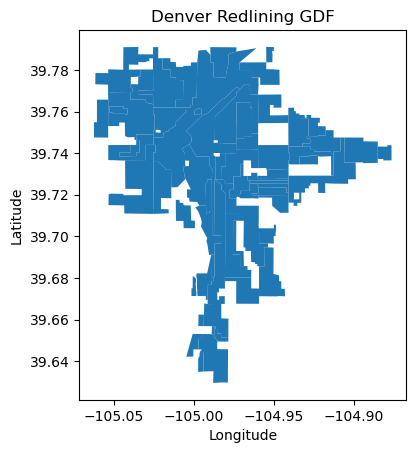

In [20]:

#Plot redlining gdf to see what CRS it is projecting as
redlining_gdf.plot(
    )
plt.gca().set(
    title = place + ' Redlining GDF', 
    xlabel='Longitude',
    ylabel='Latitude',
)
plt.show()

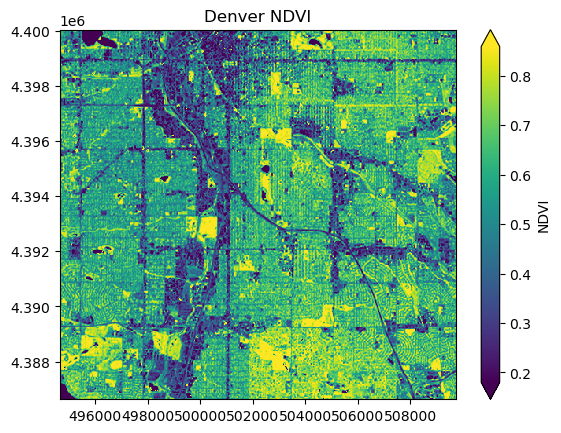

In [21]:
#Plot the ndvi_da to see CRS
ndvi_da.plot(
    cbar_kwargs={"label": "NDVI"},
    robust=True
    )
plt.gca().set(
    title = place + ' NDVI',
    xlabel='',
    ylabel='', 
)
plt.show()

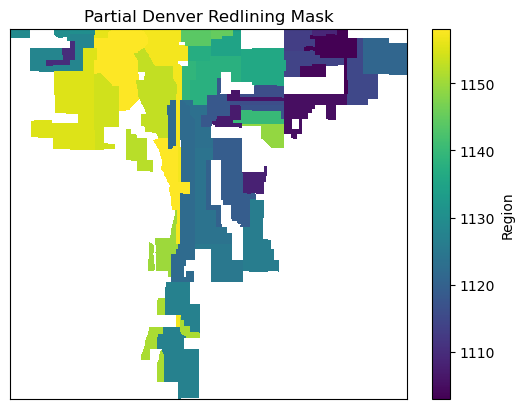

In [22]:
# Define new variable for denver redlining mask, using regionmask
redlining_mask = regionmask.mask_geopandas(
    # Put gdf in same CRS as raster
    redlining_gdf.to_crs(ndvi_da.rio.crs),
    # x and y coordinates from raster data x=504 y=447
    ndvi_da.x, ndvi_da.y,
    # The regions do not overlap
    overlap=False,
    # We're not using geographic coordinates
    wrap_lon=False,
)

# Plot the redlining mask 
redlining_mask.plot(
    cbar_kwargs={"label": "Region"},
    )
plt.gca().set(
    title = 'Partial ' + place + ' Redlining Mask', 
    xlabel='',
    ylabel='',
    xticks=[], 
    yticks=[]
)
plt.show()

## Calculate zonal statistics

Calculate zonal status using the `zonal_stats()` function.
To figure out which arguments it needs, use either the
`help()` function in Python, or search the internet.

In [23]:
# Calculate NDVI stats for each redlining zone
ndvi_stats = zonal_stats(
    redlining_mask,
    ndvi_da
)

# Call denver_ndvi_states to see the table
ndvi_stats.head()

,zone,mean,max,min,sum,std,var,count
0,1103.0,0.694627,0.975424,0.232406,1266.304565,0.083890,0.007037,1823.0
1,1104.0,0.652956,0.800656,0.461446,323.866058,0.058149,0.003381,496.0
2,1105.0,0.659457,0.933401,0.135010,1460.038574,0.103756,0.010765,2214.0
3,1106.0,0.705933,0.895803,0.235602,331.788544,0.070042,0.004906,470.0
4,1107.0,0.672849,0.859561,0.154306,411.783569,0.093026,0.008654,612.0


## Plot regional statistics

Plot the regional statistics:

1. Merge the NDVI values into the redlining `GeoDataFrame`
2. Use the code template below to convert the `grade` column
(`str` or `object` type) to an ordered `pd.Categorical` type.
This will let you use ordered color maps with the grade data.
3. Drop all `NA` grade values.
3. Plot the NDVI and the redlining grade next to each other in linked
subplots.

In [28]:
# Merge the NDVI stats with redlining geometry into one `GeoDataFrame`
redlining_ndvi_gdf = redlining_gdf.merge(
    ndvi_stats.set_index('zone'),
    left_index=True, right_index=True
)
# Change grade to ordered Categorical for plotting
redlining_ndvi_gdf.grade = pd.Categorical(
    redlining_ndvi_gdf.grade,
    ordered=True,
    categories=['A', 'B', 'C', 'D']
)

# Drop rows with NA grades
redlining_ndvi_gdf = redlining_ndvi_gdf.dropna()

print(redlining_ndvi_gdf)

# Plot NDVI and redlining grade in linked subplots
(
    redlining_ndvi_gdf.hvplot(
        c='mean',
        geo=True,
        xaxis='Longitude', 
        yaxis='Latitude',
        title = place + ' Mean NDVI',
        clabel='Mean NDVI',
        cmap='Greens'
    )
    +
    redlining_ndvi_gdf.hvplot(
        c='grade',
        geo=True,
        xaxis='Longitude', 
        yaxis='Latitude',
        title = place + ' Redlining Grades',
        cmap='cet_diverging_bwr_20_95_c54'
    )
)

        area_id    city state  city_surve              category grade label  \
1103.0     6525  Denver    CO        True                  Best     A    A1   
1104.0     6529  Denver    CO        True                  Best     A    A2   
1105.0     6537  Denver    CO        True                  Best     A    A3   
1106.0     6536  Denver    CO        True                  Best     A    A4   
1107.0     6540  Denver    CO        True                  Best     A    A5   
1108.0     6550  Denver    CO        True                  Best     A    A6   
1109.0     6526  Denver    CO        True       Still Desirable     B    B1   
1110.0     6562  Denver    CO        True       Still Desirable     B   B10   
1113.0     6527  Denver    CO        True       Still Desirable     B    B2   
1114.0     6528  Denver    CO        True       Still Desirable     B    B3   
1115.0     6524  Denver    CO        True       Still Desirable     B    B4   
1116.0     6535  Denver    CO        True       Stil

:Layout
   .Polygons.I  :Polygons   [Longitude,Latitude]   (mean)
   .Polygons.II :Polygons   [Longitude,Latitude]   (grade)

In [29]:
store redlining_ndvi_gdf

Stored 'redlining_ndvi_gdf' (GeoDataFrame)
